# Úvod

FordA dataset je vysoce kvalitní dataset časových řad určený pro binární klasifikaci. Původně byl vytvořen společností Ford pro detekcí závad v řízení automobilů na základě laboratorních testů simulovaných a skutečných systémů řízení.

Dataset obsahuje záznamy z vibrací pohonné jednotky, přičemž každý záznam má délku 500 datových bodů. Tyto časové řady reprezentují buď normální provoz (negativní třída) nebo anomální chování (pozitivní třída) pohonného systému.

Hlavním úkolem je klasifikovat dané časové řady do jedné ze dvou tříd:

- Třída -1: Normální činnost (bez závady)
- Třída 1: Anomálie (detekovaná závada)

Dataset je vyvážený a obsahuje dostatečné množství vzorků pro efektivní trénování různých modelů strojového učení, proto je populární benchmark díky své binární povaze.

# Načtení všech knihoven


In [ ]:
import os
import zipfile
import copy
from collections import defaultdict
import random

import requests
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
import seaborn as sns
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchinfo

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Nastavení stejného seedu pro reprodukovatelnost

In [2]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Kontrola dostupnosti GPU


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPU")

GPU: NVIDIA GeForce RTX 2070


# Načtení dat


## Stažení a extrakce dat


In [4]:
dataset_path = "../../datasets/FordA/"
url = "https://www.timeseriesclassification.com/aeon-toolkit/FordA.zip"
zip_file_name = "FordA.zip"

In [5]:
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

    print(f"Downloading dataset from {url}...")

    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024

    zip_path = os.path.join(dataset_path, zip_file_name)
    with open(zip_path, "wb") as f:
        progress_bar = tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading")
        for data in response.iter_content(block_size):
            f.write(data)
            progress_bar.update(len(data))

    print("Extracting files...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        file_list = zip_ref.namelist()
        for file in tqdm(file_list, desc="Extracting"):
            zip_ref.extract(file, dataset_path)

    # Remove zip file
    os.remove(zip_path)
    print("Download and extraction complete!")
else:
    print(f"Dataset already exists at {dataset_path}")

Dataset already exists at ../../datasets/FordA/


## Načtení dat do pandas DataFrame


In [6]:
train_arff_path = "../../datasets/FordA/FordA_TRAIN.arff"
test_arff_path = "../../datasets/FordA/FordA_TEST.arff"

### Načtení ARFF souborů


In [7]:
arff_train_file, _ = arff.loadarff(train_arff_path)
arff_test_file, _ = arff.loadarff(test_arff_path)

In [8]:
df_train = pd.DataFrame(arff_train_file)
df_test = pd.DataFrame(arff_test_file)

# Zobrazení dat


## Velikost dat


In [9]:
print(f"Train: {df_train.shape}\nTest: {df_test.shape}")

Train: (3601, 501)
Test: (1320, 501)


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3601 entries, 0 to 3600
Columns: 501 entries, att1 to target
dtypes: float64(500), object(1)
memory usage: 13.8+ MB


In [11]:
df_train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att492,att493,att494,att495,att496,att497,att498,att499,att500,target
0,-0.797172,-0.664392,-0.373015,0.040815,0.526936,0.984288,1.353120,1.578108,1.659251,1.640809,...,0.722417,0.362068,0.092083,-0.081268,-0.212573,-0.391456,-0.664392,-1.073796,-1.564343,b'-1'
1,0.804855,0.634629,0.373474,0.038343,-0.340988,-0.740860,-1.109667,-1.395357,-1.570192,-1.619951,...,0.049213,-0.258138,-0.510583,-0.683647,-0.773817,-0.785255,-0.714885,-0.560443,-0.319086,b'1'
2,0.727985,0.111284,-0.499124,-1.068629,-1.578351,-1.990534,-2.302031,-2.503403,-2.585211,-2.550600,...,0.463685,0.507735,0.517174,0.504588,0.476270,0.438513,0.394463,0.339400,0.255391,b'-1'
3,-0.234439,-0.502157,-0.732488,-0.946128,-1.139739,-1.323336,-1.490243,-1.607077,-1.620430,-1.506933,...,-0.929437,-0.922761,-0.929437,-0.909409,-0.835970,-0.695768,-0.478790,-0.188707,0.119736,b'-1'
4,-0.171328,-0.062285,0.235829,0.710396,1.239969,1.649823,1.876321,1.865535,1.703751,1.466467,...,0.725496,0.697453,0.731967,0.808545,0.839823,0.733046,0.437520,-0.026585,-0.602213,b'-1'


## Převod dat na číselný formát

Nyní máme cílovou proměnnou ve formátu _bytes_, tak si jej převedeme na _int_.


In [12]:
df_train['target'] = df_train['target'].astype(int)
df_test['target'] = df_test['target'].astype(int)

## Medián


In [13]:
df_train.groupby('target').mean()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att491,att492,att493,att494,att495,att496,att497,att498,att499,att500
target,,,,,,,,,,,,,,,,,,,,,
-1,-0.014895,-0.015515,-0.016355,-0.016704,-0.015422,-0.011477,-0.006306,-0.001435,0.002810,0.004730,...,0.020576,0.014972,0.006110,-0.003215,-0.010949,-0.014388,-0.012541,-0.006267,0.002245,0.010434
1,-0.018616,-0.015013,-0.010712,-0.006936,-0.004227,-0.002419,-0.000538,0.002675,0.008029,0.015609,...,-0.003742,-0.001601,0.001889,0.005288,0.007573,0.008220,0.006549,0.002857,-0.002297,-0.008113


## Směrodatná odchylka


In [14]:
df_train.groupby('target').std()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att491,att492,att493,att494,att495,att496,att497,att498,att499,att500
target,,,,,,,,,,,,,,,,,,,,,
-1,1.046503,1.038535,1.030145,1.031180,1.041815,1.051984,1.053741,1.048960,1.042726,1.03680,...,1.037209,1.037731,1.034531,1.025603,1.011854,0.997298,0.987655,0.990511,1.007039,1.028501
1,1.071179,1.066081,1.059798,1.054695,1.052556,1.053998,1.057515,1.060192,1.058752,1.05203,...,1.038403,1.043903,1.047698,1.048433,1.045641,1.040933,1.036925,1.035120,1.035589,1.036879


## Rovnováha tříd


### Trénovací sada

In [15]:
df_train.target.value_counts()

target
-1    1846
 1    1755
Name: count, dtype: int64

### Testovací sada

In [16]:
df_test.target.value_counts()

target
-1    681
 1    639
Name: count, dtype: int64

Dataset je dobře vyvážený, což by mělo usnadnit trénování. 

## Vizualizace dat


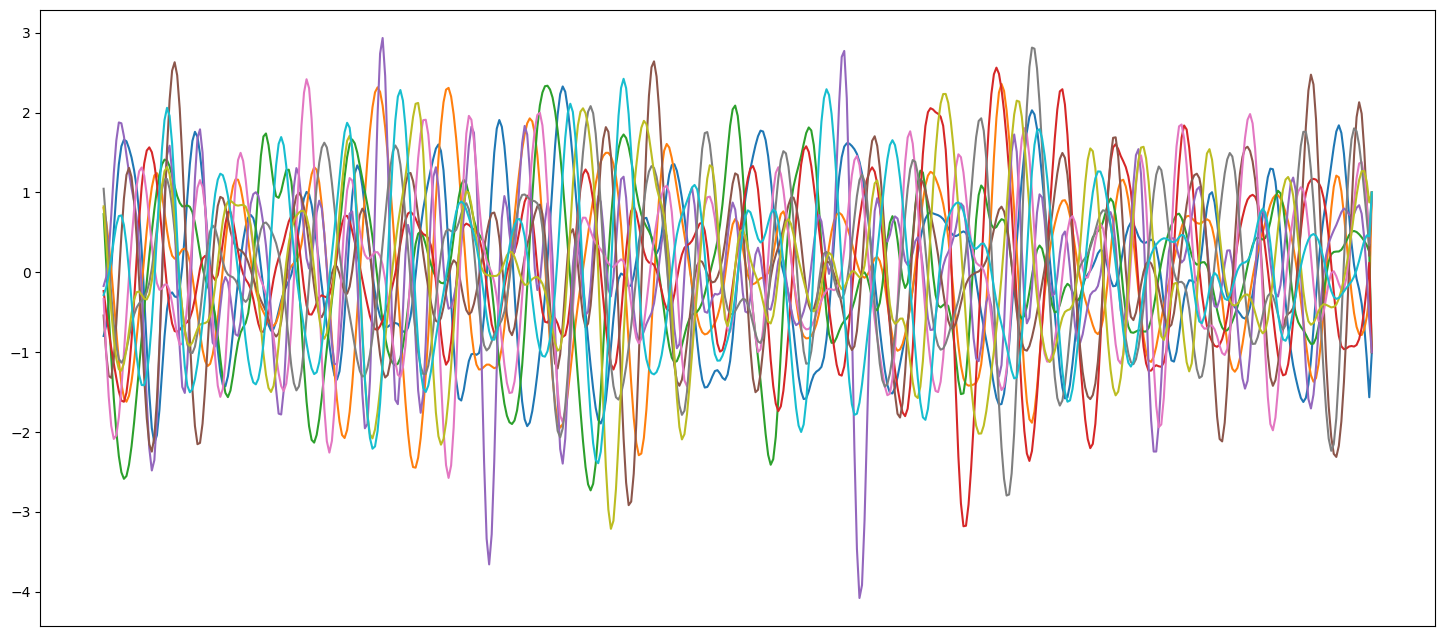

In [17]:
plt.figure(figsize=(18, 8))
for idx in range(10):
    plt.plot(df_train.iloc[idx, :])
plt.xticks([])
plt.show()

### Data s cílovým atributem -1

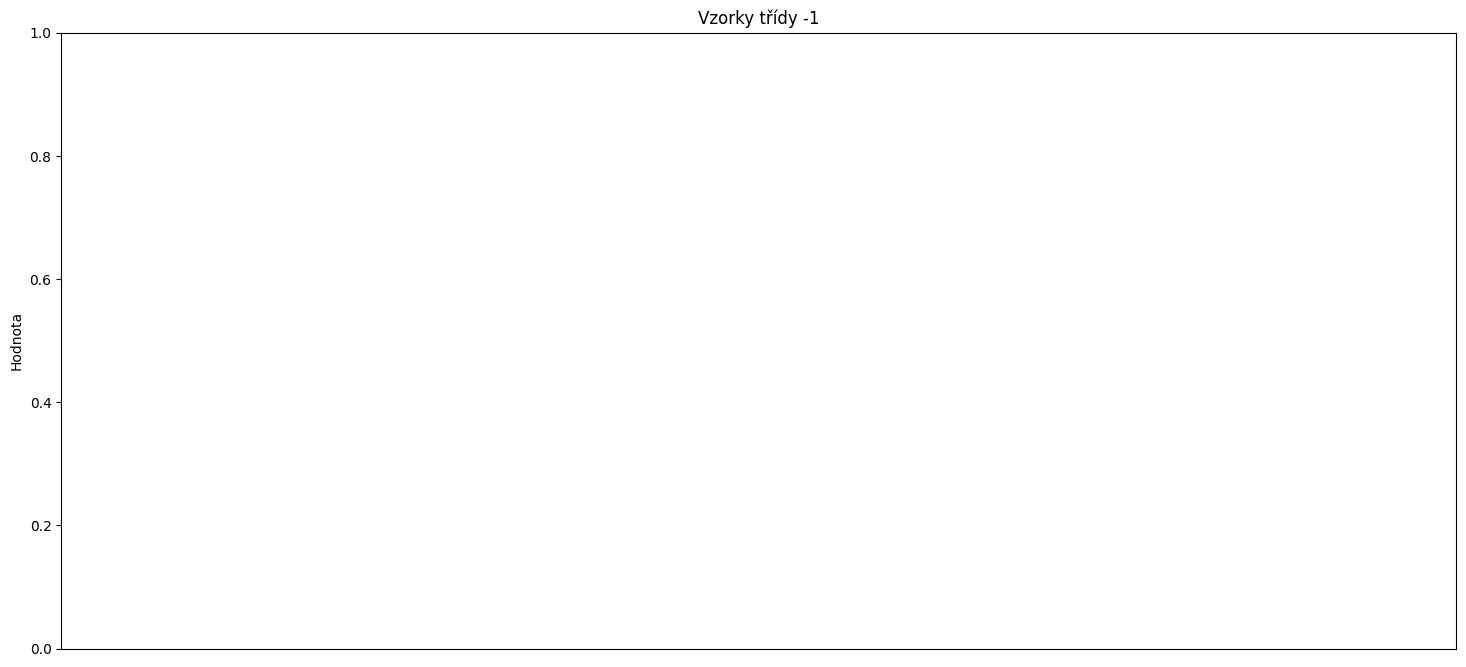

In [18]:
plt.figure(figsize=(18, 8))
negative_indices = df_test[df_test.target == 0].index[:10]  
for idx in negative_indices:
    plt.plot(df_test.iloc[idx, :-1]) 
plt.title("Vzorky třídy -1")
plt.xticks([])
plt.ylabel("Hodnota")
plt.show()

### Data s cílovým atributem 1

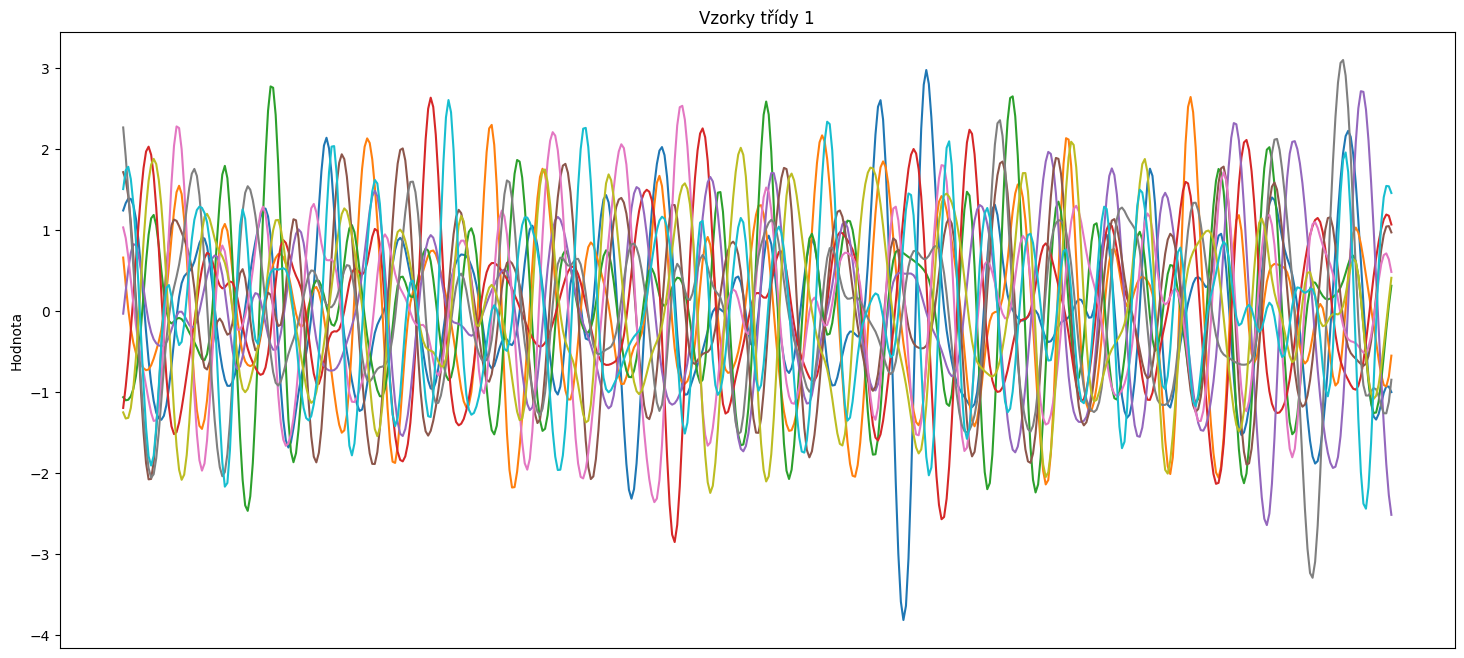

In [19]:
plt.figure(figsize=(18, 8))
positive_indices = df_test[df_test.target == 1].index[:10]
for idx in positive_indices:
    plt.plot(df_test.iloc[idx, :-1])
plt.title("Vzorky třídy 1")
plt.xticks([])
plt.ylabel("Hodnota")
plt.show()

# Příprava dat


In [20]:
X_train = df_train.drop(columns='target').values
Y_train = df_train.target.values
X_test = df_test.drop(columns='target').values
Y_test = df_test.target.values

## Převod dat na číselný formát


In [21]:
df_train['target'] = df_train['target'].astype(int)
df_test['target'] = df_test['target'].astype(int)

In [22]:
print("Unique values in Y_train:", np.unique(Y_train))
print("Unique values in Y_test:", np.unique(Y_test))

Unique values in Y_train: [-1  1]
Unique values in Y_test: [-1  1]


## Mapování tříd

Přemapujeme třídu -1 na 0 a třídu 1 na 1 pro *ReLu* a *Sigmoid* aktivaci. Pro klasické přístupy jako *Decision Tree* a *Random Forest* by to nemělo zatížit klasifikaci.


In [23]:
df_train['target'] = df_train['target'].replace({-1: 0, 1: 1})
df_test['target'] = df_test['target'].replace({-1: 0, 1: 1})

### Aktualizace hodnot


In [24]:
y_train = df_train['target'].values
y_test = df_test['target'].values

In [25]:
print("Unique values in Y_train:", np.unique(y_train))
print("Unique values in Y_test:", np.unique(y_test))

Unique values in Y_train: [0 1]
Unique values in Y_test: [0 1]


# Klasifikace pomocí strojového učení


## Decision Tree


In [26]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=42)

In [27]:
y_test_predictions_dt = dt.predict(X_test)
print(classification_report(Y_test, y_test_predictions_dt))

              precision    recall  f1-score   support

          -1       0.58      0.59      0.59       681
           1       0.56      0.55      0.56       639

    accuracy                           0.57      1320
   macro avg       0.57      0.57      0.57      1320
weighted avg       0.57      0.57      0.57      1320



## Random Forest


In [28]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [29]:
y_test_predictions_rf = rf.predict(X_test)
print(classification_report(Y_test, y_test_predictions_rf))

              precision    recall  f1-score   support

          -1       0.73      0.79      0.76       681
           1       0.76      0.68      0.72       639

    accuracy                           0.74      1320
   macro avg       0.74      0.74      0.74      1320
weighted avg       0.74      0.74      0.74      1320



## Gradient Boosting


In [30]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, Y_train)

GradientBoostingClassifier(random_state=42)

In [31]:
y_test_predictions_gb = gb.predict(X_test)
print(classification_report(Y_test, y_test_predictions_gb))

              precision    recall  f1-score   support

          -1       0.65      0.74      0.69       681
           1       0.67      0.58      0.62       639

    accuracy                           0.66      1320
   macro avg       0.66      0.66      0.66      1320
weighted avg       0.66      0.66      0.66      1320



# Klasifikace pomocí neuronových sítí


### Příprava dat pro trénování


In [32]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(y_test, dtype=torch.long)

## Příprava dat pro konvoluční neuronové sítě

V této buňce upravujeme tvar našich tenzorů tak, aby byly kompatibilní s konvolučními vrstvami (`Conv1d`).

Konvoluční vrstvy v PyTorch očekávají vstupní data ve formátu:
- **[batch_size, channels, sequence_length]**

Naše současná data jsou ve formátu:
- **[batch_size, sequence_length]**

Přidáním dimenze kanálů pomocí metody `unsqueeze(1)` transformujeme naše data do požadovaného formátu. V našem případě používáme jednokanálová data (jako u jednorozměrného signálu), takže přidáváme kanál s hodnotou 1.

Toto je běžný krok při zpracování časových řad pomocí konvolučních neuronových sítí, kde každá časová řada je reprezentována jako jednokanálový signál.

In [33]:
X_train_tensor = X_train_tensor.unsqueeze(1)  
X_test_tensor = X_test_tensor.unsqueeze(1)

In [34]:
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

In [35]:
print(X_train_tensor.shape)
print(Y_train_tensor.shape)
print(X_test_tensor.shape)
print(Y_test_tensor.shape)

torch.Size([3601, 1, 500])
torch.Size([3601])
torch.Size([1320, 1, 500])
torch.Size([1320])


#### Trénovací parametry


In [36]:
batch_size = 64
num_epochs = 50
learning_rate = 0.001
class_names = ['0', '1']
num_classes = len(torch.unique(Y_train_tensor))

#### DataLoader


In [37]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Pomocné funkce


#### Funkce pro trénování modelu


In [38]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Print header
    print(f"{'Epoch':<7} | {'Train Loss':<12} | {'Train Acc':<10} | Improvement")
    print("-" * 50)

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        total_samples = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()
            total_samples += inputs.size(0)

        # Calculate metrics
        epoch_loss = train_loss / total_samples
        epoch_acc = train_correct / total_samples
        
        # Store metrics
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Check for improvement
        improvement = ""
        if epoch_acc > best_acc:
            improvement = "✓"
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())            

        print(f"{epoch + 1:>3}/{num_epochs:<3} | {epoch_loss:>10.4f} | {epoch_acc:>9.2%} | {improvement}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f"\nTraining complete! Best accuracy: {best_acc:.2%}")

    return model, history

#### Funkce pro vykreslení historie trénování


In [39]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Trénovací ztráta')
    plt.xlabel('Epocha')
    plt.ylabel('Ztráta')
    plt.legend()
    plt.title('Ztráta během epoch')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Trénovací přesnost')
    plt.xlabel('Epocha')
    plt.ylabel('Přesnost')
    plt.legend()
    plt.title('Přesnost během epoch')

    plt.tight_layout()
    plt.show()


#### Funkce pro vyhodnocení modelu


In [40]:
def evaluate_model(model, test_loader, device, class_names=None):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, prediction = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(prediction.cpu().numpy())

    # Calculate metrics
    accuracy = (np.array(all_predictions) == np.array(all_labels)).mean()
    report = classification_report(
        all_labels,
        all_predictions,
        target_names=class_names,
        digits=4,
        zero_division=1,
        output_dict=True
    )

    # Print results
    print(f"\n{' Test Results ':=^40}")
    print(f"Overall Accuracy: {accuracy:.2%}\n")
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names, digits=4, zero_division=1))

    # Plot confusion matrix if class_names are provided
    if class_names:
        cm = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, cbar=False)
        plt.title('Matice záměny')
        plt.xlabel('Predikce')
        plt.ylabel('Skutečné hodnoty')
        plt.tight_layout()
        plt.show()

    # Return metrics dictionary
    metrics = {
        'Accuracy': accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-score': report['weighted avg']['f1-score']
    }

    return metrics

### Trénování jednotlivých modelů


#### RNN


In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_channels=1, num_classes=2):
        super(RNNModel, self).__init__()
        
        self.cnn = nn.Sequential(
            # Block 1
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Block 2
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Block 3
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # RNN Temporal Processor
        self.rnn = nn.RNN(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            nonlinearity='relu'
        )
        
        # Classifier Head with Sigmoid
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes),
            nn.Sigmoid() 
        )

    
    def forward(self, x):
        # CNN Feature Extraction
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.squeeze(-1)  # Remove the last dimension 
        
        # RNN Processing - add a sequence dimension
        cnn_features = cnn_features.unsqueeze(1)  # [batch, 1, features]
        h0 = torch.zeros(2, x.size(0), 128).to(x.device)  # 2 layers
        rnn_out, _ = self.rnn(cnn_features, h0)
        rnn_features = rnn_out[:, -1, :]  # Last timestep
        
        # Classification
        logits = self.classifier(rnn_features)
        return logits

In [42]:
input_size = 1
hidden_size = 64
num_layers = 3
dropout = 0.5

In [43]:
model = RNNModel(input_size, num_classes).to(device)
torchinfo.summary(model, input_size=(batch_size, input_size, X_train.shape[1]), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
RNNModel                                 [64, 1, 500]              [64, 2]                   --
├─Sequential: 1-1                        [64, 1, 500]              [64, 256, 1]              --
│    └─Conv1d: 2-1                       [64, 1, 500]              [64, 64, 500]             512
│    └─BatchNorm1d: 2-2                  [64, 64, 500]             [64, 64, 500]             128
│    └─ReLU: 2-3                         [64, 64, 500]             [64, 64, 500]             --
│    └─MaxPool1d: 2-4                    [64, 64, 500]             [64, 64, 250]             --
│    └─Conv1d: 2-5                       [64, 64, 250]             [64, 128, 250]            41,088
│    └─BatchNorm1d: 2-6                  [64, 128, 250]            [64, 128, 250]            256
│    └─ReLU: 2-7                         [64, 128, 250]            [64, 128, 250]            --
│    └─MaxPool1d: 2-8       

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [45]:
rnn_model, rnn_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.5120 |    80.84% | ✓
  2/50  |     0.4265 |    88.48% | ✓
  3/50  |     0.4105 |    90.17% | ✓
  4/50  |     0.3950 |    91.45% | ✓
  5/50  |     0.4007 |    91.09% | 
  6/50  |     0.3964 |    91.45% | 
  7/50  |     0.4050 |    90.39% | 
  8/50  |     0.3903 |    92.11% | ✓
  9/50  |     0.3896 |    92.00% | 
 10/50  |     0.3859 |    92.59% | ✓
 11/50  |     0.3996 |    91.11% | 
 12/50  |     0.3843 |    92.50% | 
 13/50  |     0.3993 |    90.86% | 
 14/50  |     0.3765 |    93.53% | ✓
 15/50  |     0.3816 |    92.97% | 
 16/50  |     0.3884 |    92.45% | 
 17/50  |     0.3808 |    93.00% | 
 18/50  |     0.3730 |    93.81% | ✓
 19/50  |     0.3784 |    93.22% | 
 20/50  |     0.3778 |    93.42% | 
 21/50  |     0.3808 |    93.14% | 
 22/50  |     0.3710 |    94.06% | ✓
 23/50  |     0.3786 |    93.39% | 
 24/50  |     0.3883 |    92.31% | 
 25/50  |     0.3773 |    

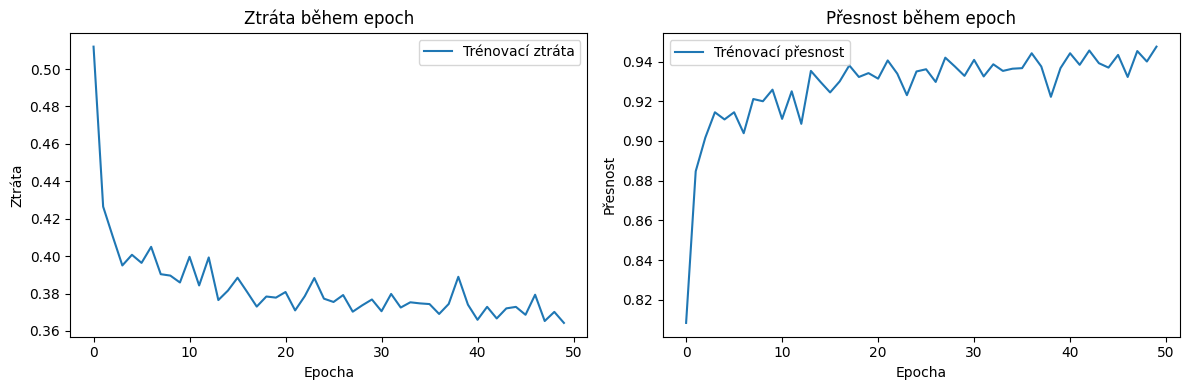

In [46]:
plot_training_history(rnn_history)


============= Test Results =============
Overall Accuracy: 91.82%

Classification Report:
              precision    recall  f1-score   support

           0     0.9897    0.8502    0.9147       681
           1     0.8612    0.9906    0.9214       639

    accuracy                         0.9182      1320
   macro avg     0.9255    0.9204    0.9180      1320
weighted avg     0.9275    0.9182    0.9179      1320



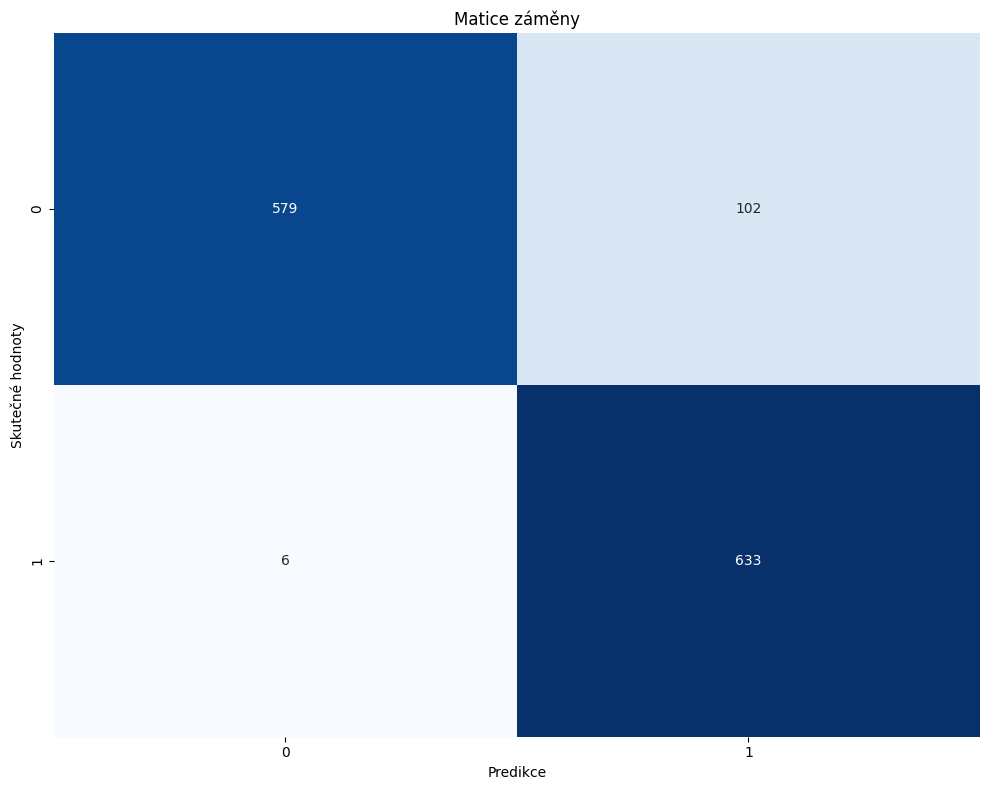

In [47]:
rnn_metrics = evaluate_model(rnn_model, test_loader, device, class_names)

#### GRU


In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=2, num_classes=2, dropout=0.3):
        super(GRUModel, self).__init__()

        # Save parameters as instance attributes
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 1. CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # 2. GRU Temporal Processor
        self.gru = nn.GRU(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )

        # 3. Enhanced Classifier with ReLU and Sigmoid
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),

            nn.Linear(hidden_size // 2, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 1. CNN Feature Extraction
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.squeeze(-1)  # Remove length dimension

        # 2. Prepare for GRU (add sequence dimension back)
        gru_input = cnn_features.unsqueeze(1)  # [batch, 1, hidden_size]

        # 3. GRU Processing
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        gru_out, _ = self.gru(gru_input, h0)
        gru_out = gru_out[:, -1, :]  # Last timestep

        # 4. Classification
        logits = self.classifier(gru_out)
        return logits

In [49]:
model = GRUModel(input_size, hidden_size, num_layers, num_classes, dropout).to(device)
torchinfo.summary(model, input_size=(batch_size, input_size, X_train.shape[1]), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
GRUModel                                 [64, 1, 500]              [64, 2]                   --
├─Sequential: 1-1                        [64, 1, 500]              [64, 64, 1]               --
│    └─Conv1d: 2-1                       [64, 1, 500]              [64, 64, 500]             512
│    └─BatchNorm1d: 2-2                  [64, 64, 500]             [64, 64, 500]             128
│    └─ReLU: 2-3                         [64, 64, 500]             [64, 64, 500]             --
│    └─MaxPool1d: 2-4                    [64, 64, 500]             [64, 64, 250]             --
│    └─Conv1d: 2-5                       [64, 64, 250]             [64, 128, 250]            41,088
│    └─BatchNorm1d: 2-6                  [64, 128, 250]            [64, 128, 250]            256
│    └─ReLU: 2-7                         [64, 128, 250]            [64, 128, 250]            --
│    └─MaxPool1d: 2-8       

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
gru_model, gru_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.5963 |    77.20% | ✓
  2/50  |     0.4800 |    87.78% | ✓
  3/50  |     0.4398 |    89.50% | ✓
  4/50  |     0.4266 |    89.42% | 
  5/50  |     0.4145 |    90.64% | ✓
  6/50  |     0.4048 |    91.31% | ✓
  7/50  |     0.4001 |    91.25% | 
  8/50  |     0.3970 |    91.75% | ✓
  9/50  |     0.3915 |    92.06% | ✓
 10/50  |     0.3993 |    91.25% | 
 11/50  |     0.3889 |    92.17% | ✓
 12/50  |     0.3782 |    93.61% | ✓
 13/50  |     0.3835 |    92.84% | 
 14/50  |     0.3827 |    92.81% | 
 15/50  |     0.3896 |    92.11% | 
 16/50  |     0.3842 |    92.72% | 
 17/50  |     0.3803 |    93.42% | 
 18/50  |     0.3843 |    92.72% | 
 19/50  |     0.3845 |    92.84% | 
 20/50  |     0.3793 |    93.28% | 
 21/50  |     0.3739 |    93.75% | ✓
 22/50  |     0.3805 |    92.95% | 
 23/50  |     0.3822 |    92.78% | 
 24/50  |     0.3858 |    92.59% | 
 25/50  |     0.3847 |   

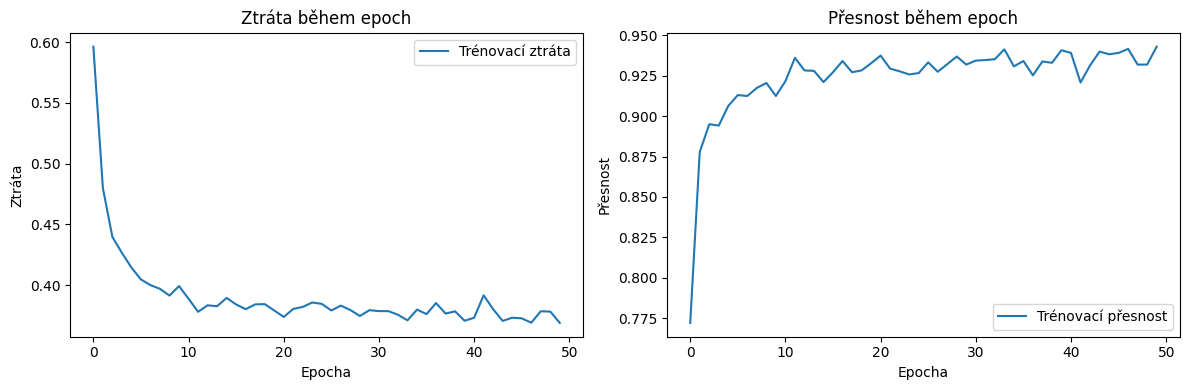

In [52]:
plot_training_history(gru_history)


============= Test Results =============
Overall Accuracy: 93.48%

Classification Report:
              precision    recall  f1-score   support

           0     0.9293    0.9457    0.9374       681
           1     0.9410    0.9233    0.9321       639

    accuracy                         0.9348      1320
   macro avg     0.9351    0.9345    0.9347      1320
weighted avg     0.9350    0.9348    0.9348      1320



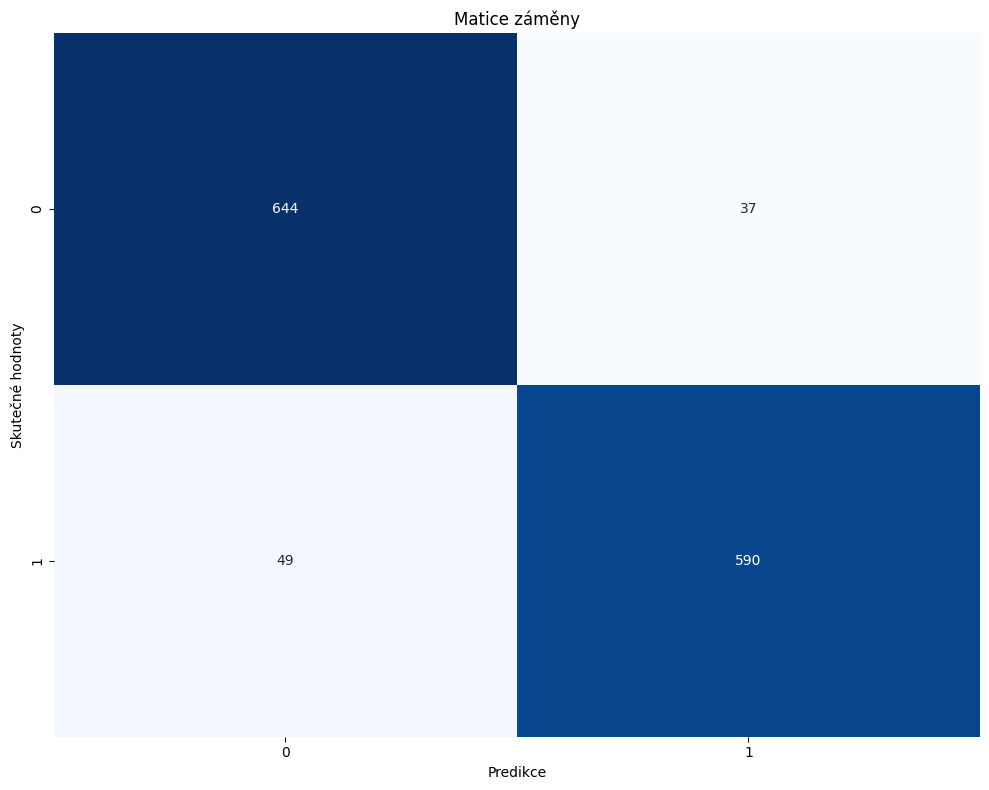

In [53]:
gru_metrics = evaluate_model(gru_model, test_loader, device, class_names)

#### LSTM


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=2, num_classes=2, dropout=0.3):
        super(LSTMModel, self).__init__()

        # Save parameters as instance attributes
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 1. CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # 2. LSTM Processor
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )

        # 3. Enhanced Classifier with ReLU and Sigmoid
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, num_classes),
            nn.Sigmoid()  # Added Sigmoid activation
        )

    def forward(self, x):            
        # 1. CNN Feature Extraction
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.squeeze(-1)  # Remove length dimension

        # 2. Prepare for LSTM (add sequence dimension back)
        lstm_input = cnn_features.unsqueeze(1)  # [batch, 1, hidden_size]

        # 3. LSTM Processing
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(lstm_input, (h0, c0))
        lstm_out = lstm_out[:, -1, :]  # Last timestep

        # 4. Classification
        logits = self.classifier(lstm_out)
        return logits

In [55]:
model = LSTMModel(input_size, hidden_size, num_layers, num_classes, dropout).to(device)
torchinfo.summary(model, input_size=(batch_size, input_size, X_train.shape[1]), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [64, 1, 500]              [64, 2]                   --
├─Sequential: 1-1                        [64, 1, 500]              [64, 64, 1]               --
│    └─Conv1d: 2-1                       [64, 1, 500]              [64, 64, 500]             512
│    └─BatchNorm1d: 2-2                  [64, 64, 500]             [64, 64, 500]             128
│    └─ReLU: 2-3                         [64, 64, 500]             [64, 64, 500]             --
│    └─MaxPool1d: 2-4                    [64, 64, 500]             [64, 64, 250]             --
│    └─Conv1d: 2-5                       [64, 64, 250]             [64, 128, 250]            41,088
│    └─BatchNorm1d: 2-6                  [64, 128, 250]            [64, 128, 250]            256
│    └─ReLU: 2-7                         [64, 128, 250]            [64, 128, 250]            --
│    └─MaxPool1d: 2-8       

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [57]:
lstm_model, lstm_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.6197 |    72.56% | ✓
  2/50  |     0.4878 |    87.45% | ✓
  3/50  |     0.4433 |    88.89% | ✓
  4/50  |     0.4192 |    90.53% | ✓
  5/50  |     0.4114 |    90.59% | ✓
  6/50  |     0.4011 |    91.70% | ✓
  7/50  |     0.3939 |    91.86% | ✓
  8/50  |     0.3999 |    91.36% | 
  9/50  |     0.3934 |    91.89% | ✓
 10/50  |     0.3935 |    91.84% | 
 11/50  |     0.3964 |    91.36% | 
 12/50  |     0.3822 |    93.14% | ✓
 13/50  |     0.3926 |    91.64% | 
 14/50  |     0.3849 |    92.70% | 
 15/50  |     0.3899 |    92.14% | 
 16/50  |     0.3901 |    92.17% | 
 17/50  |     0.3778 |    93.56% | ✓
 18/50  |     0.3868 |    92.56% | 
 19/50  |     0.3864 |    92.53% | 
 20/50  |     0.3767 |    93.70% | ✓
 21/50  |     0.3777 |    93.36% | 
 22/50  |     0.3863 |    92.70% | 
 23/50  |     0.3811 |    92.92% | 
 24/50  |     0.3784 |    93.20% | 
 25/50  |     0.3813 |  

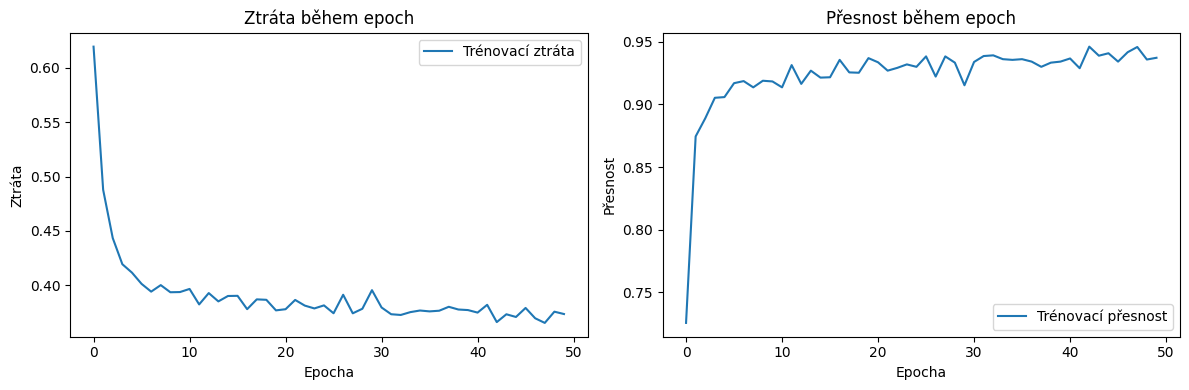

In [58]:
plot_training_history(lstm_history)


============= Test Results =============
Overall Accuracy: 93.11%

Classification Report:
              precision    recall  f1-score   support

           0     0.9167    0.9530    0.9345       681
           1     0.9477    0.9077    0.9273       639

    accuracy                         0.9311      1320
   macro avg     0.9322    0.9303    0.9309      1320
weighted avg     0.9317    0.9311    0.9310      1320



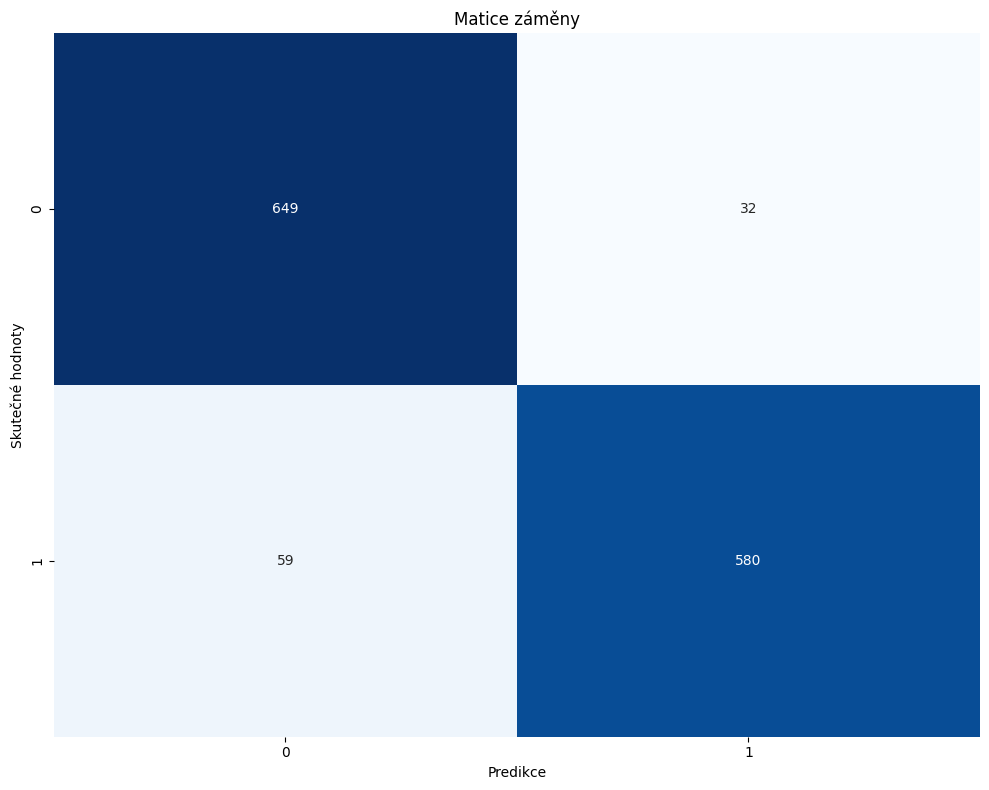

In [59]:
lstm_metrics = evaluate_model(lstm_model, test_loader, device, class_names)

#### Bidirectional LSTM

In [64]:
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=2, num_classes=2, dropout=0.3):
        super(BidirectionalLSTMModel, self).__init__()

        # Save parameters as instance attributes
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 1. CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # 2. Bidirectional LSTM Processor
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        # 3. Enhanced Classifier with ReLU and Sigmoid
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, hidden_size // 2),  # Multiply by 2 for bidirectional
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, num_classes),
            nn.Sigmoid()  # Added Sigmoid activation like other models
        )

    def forward(self, x):     
        # 1. CNN Feature Extraction
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.squeeze(-1)  # Remove length dimension
        
        # 2. Prepare for LSTM (add sequence dimension back)
        lstm_input = cnn_features.unsqueeze(1)  # [batch, 1, hidden_size]      

        # 3. LSTM Processing
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(lstm_input, (h0, c0))
        lstm_out = lstm_out[:, -1, :]  # Last timestep
        
        # 4. Classification
        logits = self.classifier(lstm_out)
        return logits


In [65]:
model = BidirectionalLSTMModel(input_size, hidden_size, num_layers, num_classes, dropout).to(device)
torchinfo.summary(model, input_size=(batch_size, input_size, X_train.shape[1]), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
BidirectionalLSTMModel                   [64, 1, 500]              [64, 2]                   --
├─Sequential: 1-1                        [64, 1, 500]              [64, 64, 1]               --
│    └─Conv1d: 2-1                       [64, 1, 500]              [64, 64, 500]             512
│    └─BatchNorm1d: 2-2                  [64, 64, 500]             [64, 64, 500]             128
│    └─ReLU: 2-3                         [64, 64, 500]             [64, 64, 500]             --
│    └─MaxPool1d: 2-4                    [64, 64, 500]             [64, 64, 250]             --
│    └─Conv1d: 2-5                       [64, 64, 250]             [64, 128, 250]            41,088
│    └─BatchNorm1d: 2-6                  [64, 128, 250]            [64, 128, 250]            256
│    └─ReLU: 2-7                         [64, 128, 250]            [64, 128, 250]            --
│    └─MaxPool1d: 2-8       

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [67]:
bidirectional_lstm_model, bidirectional_lstm_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.6099 |    72.12% | ✓
  2/50  |     0.4793 |    87.98% | ✓
  3/50  |     0.4271 |    90.31% | ✓
  4/50  |     0.4096 |    91.39% | ✓
  5/50  |     0.3987 |    91.89% | ✓
  6/50  |     0.3920 |    92.36% | ✓
  7/50  |     0.3877 |    92.78% | ✓
  8/50  |     0.3923 |    92.14% | 
  9/50  |     0.3829 |    93.09% | ✓
 10/50  |     0.3942 |    91.78% | 
 11/50  |     0.3888 |    92.28% | 
 12/50  |     0.3778 |    93.61% | ✓
 13/50  |     0.3853 |    92.67% | 
 14/50  |     0.3799 |    93.36% | 
 15/50  |     0.3908 |    92.11% | 
 16/50  |     0.3757 |    93.67% | ✓
 17/50  |     0.3861 |    92.64% | 
 18/50  |     0.3808 |    93.11% | 
 19/50  |     0.3765 |    93.67% | 
 20/50  |     0.3723 |    93.78% | ✓
 21/50  |     0.3880 |    92.14% | 
 22/50  |     0.3776 |    93.03% | 
 23/50  |     0.3740 |    93.70% | 
 24/50  |     0.3750 |    93.70% | 
 25/50  |     0.3774 |  

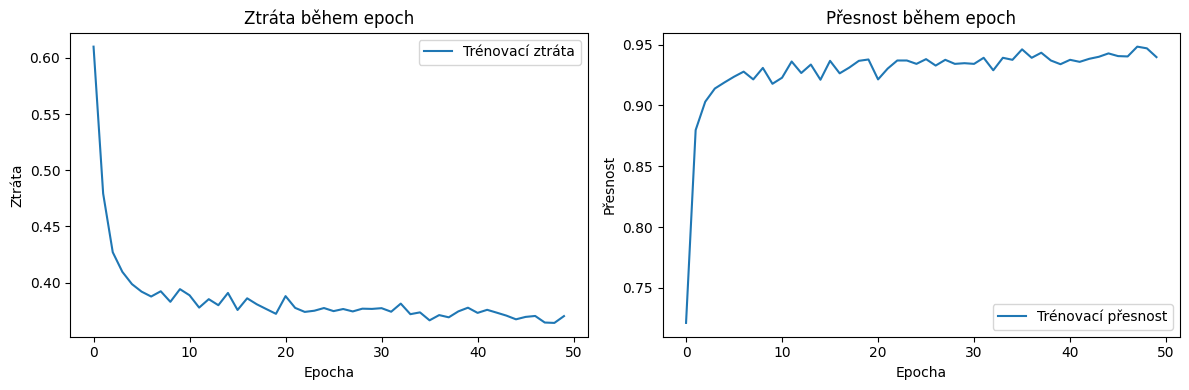

In [68]:
plot_training_history(bidirectional_lstm_history)


============= Test Results =============
Overall Accuracy: 90.45%

Classification Report:
              precision    recall  f1-score   support

           0     0.8590    0.9750    0.9133       681
           1     0.9689    0.8294    0.8938       639

    accuracy                         0.9045      1320
   macro avg     0.9140    0.9022    0.9036      1320
weighted avg     0.9122    0.9045    0.9039      1320



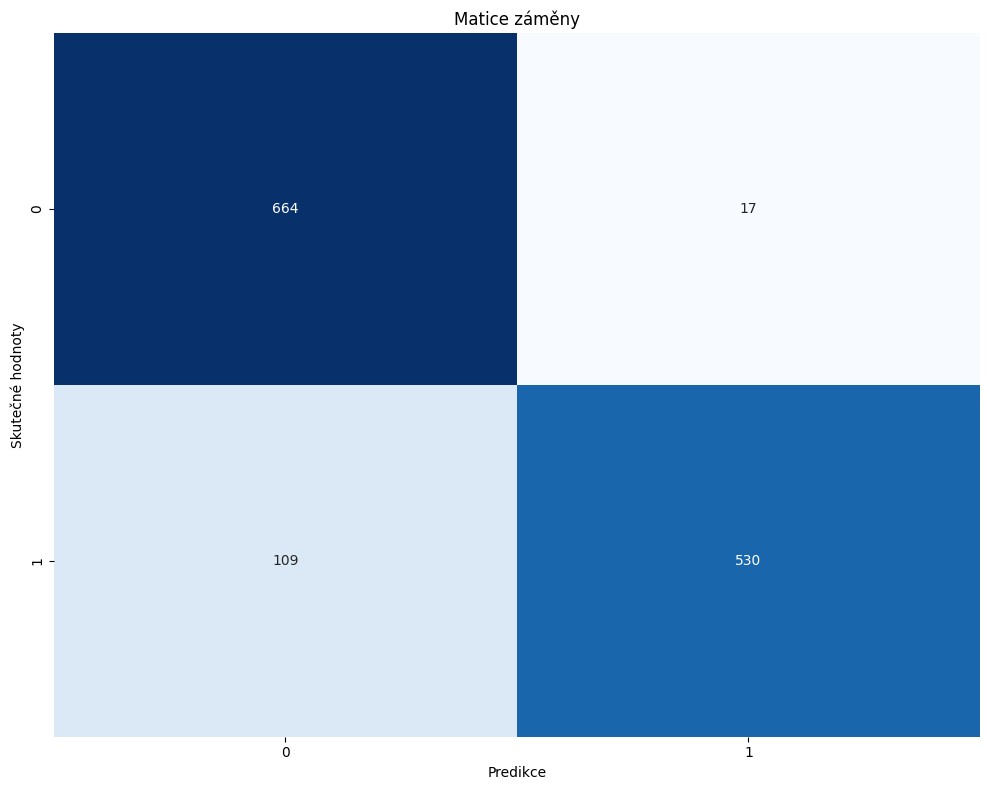

In [69]:
bidirectional_lstm_metrics = evaluate_model(bidirectional_lstm_model, test_loader, device, class_names)

#### CNN


In [83]:
class CNNModel(nn.Module):
    def __init__(self, input_channels=1, num_classes=2):
        super(CNNModel, self).__init__()
        
        # Feature extraction with CNN blocks - reduced to 3 blocks
        self.features = nn.Sequential(
            # Block 1
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Block 2
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            # Block 3
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        # Classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Sigmoid()  
        )

    def forward(self, x):          
        # Feature extraction
        x = self.features(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Classification
        x = self.classifier(x)
        return x


In [84]:
model = CNNModel(input_channels=1, num_classes=num_classes).to(device)
torchinfo.summary(model, input_size=(batch_size, input_size, X_train.shape[1]), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CNNModel                                 [64, 1, 500]              [64, 2]                   --
├─Sequential: 1-1                        [64, 1, 500]              [64, 256, 1]              --
│    └─Conv1d: 2-1                       [64, 1, 500]              [64, 64, 500]             512
│    └─BatchNorm1d: 2-2                  [64, 64, 500]             [64, 64, 500]             128
│    └─ReLU: 2-3                         [64, 64, 500]             [64, 64, 500]             --
│    └─MaxPool1d: 2-4                    [64, 64, 500]             [64, 64, 250]             --
│    └─Conv1d: 2-5                       [64, 64, 250]             [64, 128, 250]            41,088
│    └─BatchNorm1d: 2-6                  [64, 128, 250]            [64, 128, 250]            256
│    └─ReLU: 2-7                         [64, 128, 250]            [64, 128, 250]            --
│    └─MaxPool1d: 2-8       

In [85]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [86]:
cnn_model, cnn_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.5507 |    78.37% | ✓
  2/50  |     0.4386 |    87.36% | ✓
  3/50  |     0.4249 |    88.48% | ✓
  4/50  |     0.4153 |    89.17% | ✓
  5/50  |     0.4100 |    90.25% | ✓
  6/50  |     0.4041 |    90.75% | ✓
  7/50  |     0.4030 |    90.72% | 
  8/50  |     0.4062 |    90.45% | 
  9/50  |     0.3948 |    91.75% | ✓
 10/50  |     0.4043 |    90.42% | 
 11/50  |     0.3916 |    92.09% | ✓
 12/50  |     0.3944 |    91.50% | 
 13/50  |     0.3946 |    91.53% | 
 14/50  |     0.3940 |    91.70% | 
 15/50  |     0.3944 |    91.53% | 
 16/50  |     0.3960 |    91.11% | 
 17/50  |     0.3914 |    91.86% | 
 18/50  |     0.3873 |    92.36% | ✓
 19/50  |     0.3969 |    91.42% | 
 20/50  |     0.3967 |    91.06% | 
 21/50  |     0.3887 |    92.20% | 
 22/50  |     0.3874 |    92.34% | 
 23/50  |     0.3850 |    92.50% | ✓
 24/50  |     0.3827 |    92.84% | ✓
 25/50  |     0.3845 |  

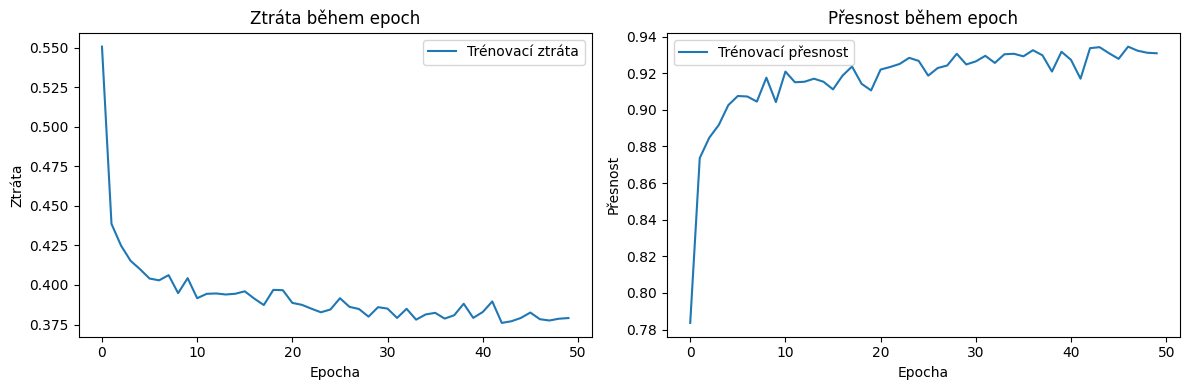

In [87]:
plot_training_history(cnn_history)


============= Test Results =============
Overall Accuracy: 91.44%

Classification Report:
              precision    recall  f1-score   support

           0     0.8827    0.9618    0.9206       681
           1     0.9550    0.8638    0.9071       639

    accuracy                         0.9144      1320
   macro avg     0.9189    0.9128    0.9139      1320
weighted avg     0.9177    0.9144    0.9141      1320



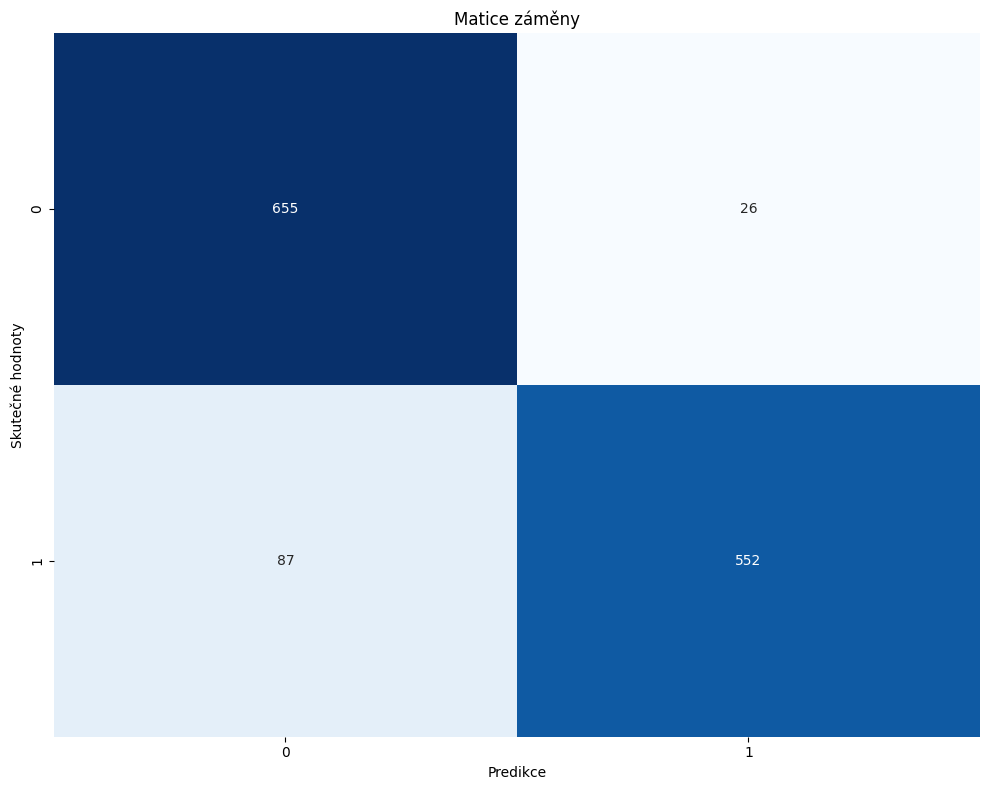

In [88]:
cnn_metrics = evaluate_model(cnn_model, test_loader, device, class_names)

# Výsledky


## Porovnání výsledků klasických metod


In [103]:
classic_results = {
    'Model': ['Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [
        classification_report(Y_test, y_test_predictions_dt, output_dict=True)['accuracy'],
        classification_report(Y_test, y_test_predictions_rf, output_dict=True)['accuracy'],
        classification_report(Y_test, y_test_predictions_gb, output_dict=True)['accuracy']
    ]
}

results_classic = pd.DataFrame(classic_results)
results_classic = results_classic.set_index('Model')
results_classic = results_classic.sort_values(by='Accuracy', ascending=False)

In [104]:
results_classic

,Accuracy
Model,
Random Forest,0.740909
Gradient Boosting,0.659848
Decision Tree,0.571212


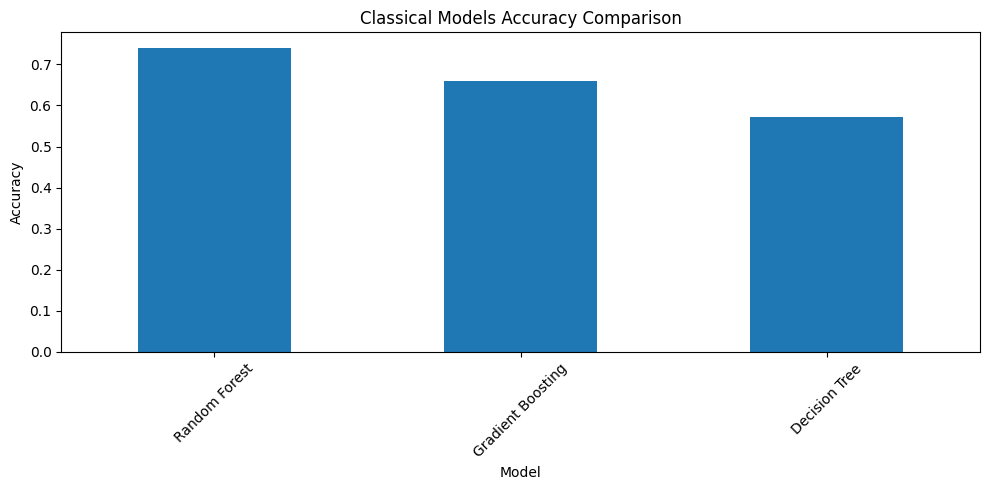

In [105]:
plt.figure(figsize=(10, 5))
results_classic['Accuracy'].plot(kind='bar')
plt.title('Classical Models Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Porovnání výsledků neuronových sítí


In [100]:
nn_results = {
    'Model': ['RNN', 'GRU', 'LSTM', 'Bidirectional LSTM', 'CNN'],
    'Accuracy': [
        rnn_metrics['Accuracy'],
        gru_metrics['Accuracy'],
        lstm_metrics['Accuracy'],
        bidirectional_lstm_metrics['Accuracy'],
        cnn_metrics['Accuracy']
    ],
    'Precision': [
        rnn_metrics['Precision'],
        gru_metrics['Precision'],
        lstm_metrics['Precision'],
        bidirectional_lstm_metrics['Precision'],
        cnn_metrics['Precision']
    ],
    'Recall': [
        rnn_metrics['Recall'],
        gru_metrics['Recall'],
        lstm_metrics['Recall'],
        bidirectional_lstm_metrics['Recall'],
        cnn_metrics['Recall']
    ],
    'F1-score': [
        rnn_metrics['F1-score'],
        gru_metrics['F1-score'],
        lstm_metrics['F1-score'],
        bidirectional_lstm_metrics['F1-score'],
        cnn_metrics['F1-score']
    ]
}

In [101]:
results_nn = pd.DataFrame(nn_results)
results_nn = results_nn.set_index('Model')

In [102]:
results_nn_sorted = results_nn.sort_values(by='Accuracy', ascending=False)
results_nn_sorted

,Accuracy,Precision,Recall,F1-score
Model,,,,
GRU,0.934848,0.934955,0.934848,0.934824
LSTM,0.931061,0.931696,0.931061,0.930987
RNN,0.918182,0.927529,0.918182,0.917938
CNN,0.914394,0.917734,0.914394,0.914083
Bidirectional LSTM,0.904545,0.912207,0.904545,0.903863


<Figure size 1200x600 with 0 Axes>

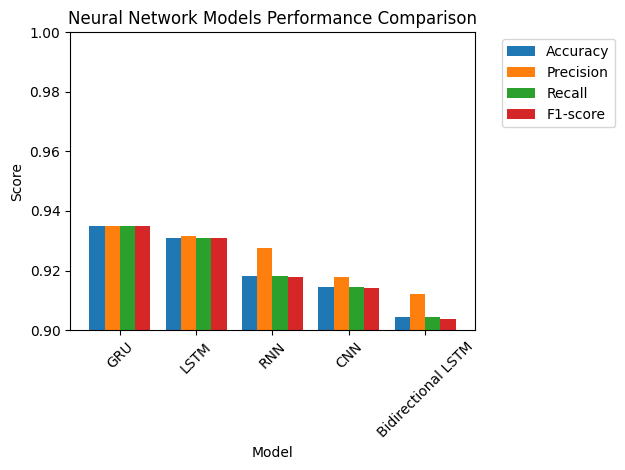

In [ ]:
plt.figure(figsize=(12, 6))
results_nn_sorted.plot(kind='bar', width=0.8)
plt.title('Neural Network Models Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.9, 1.0)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()